In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_dc_multidim import model_dc_multidim
import egm_dc_multidim as egm
import time

In [3]:
model = model_dc_multidim()
model.setup()
model.create_grids()

In [6]:
t0 = time.time()  # set the starting time
model = model_dc_multidim()
model.setup()
model.create_grids()
model.solve()
t1 = time.time() # set the ending time
print(f'time: {t1-t0:.8} seconds') # print the total time

88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
time: 550.38281 seconds


In [407]:
egm.human_capital(1, 60, model.par)

53.49402684971406

In [132]:
w = np.random.uniform(size=(5)) 
w = w / np.sum(w)
np.random.choice(np.array([2,3,4,5,7]), p = w )

4

In [409]:
def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def tax_fun(income, par):
    thld_1 = 17.3918
    thld_2 = 73.1766

    if income < thld_1:
        return 0 * income
    if income < thld_2:
        return 0.29907 * (income - thld_1)
    return 0.37930 * (income - thld_2) + 0.29907 * thld_2

def human_capital(e, t, par, tau=("cg","high")):
    edu, skill = tau
    t -= 20
    return np.exp(par.eta_0[edu] + par.eta_0[skill] + par.eta_1[edu] * t*e + par.eta_2[edu] * (t*e)**2 + par.eta_3*t + par.eta_4*t**2)

def soft_max(x, y):
    v = 0.3
    return v * np.log(np.exp(x/v) + np.exp(y/v))

def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def res(V, sigma):
    # Maximum over the discrete choices (0 = for each column, i.e., for each "competing choice")
    mxm = V.max(0)
    # numerically robust log-sum
    log_sum = mxm + sigma*(np.log(np.sum(np.exp((V - mxm) / sigma),axis=0)))
    prob = np.exp((V- log_sum) / sigma)    
    return prob    

def simulate (model):
    par = model.par
    sol = model.sol
    sim = model.sim
    
    par.simT = par.T
    
    # Initialize
    shape = (par.simT, par.simN)
    sim.m = np.nan +np.zeros(shape)
    sim.c = np.nan +np.zeros(shape)
    sim.a = np.nan +np.zeros(shape)
    sim.e = np.nan +np.zeros(shape)
    sim.income = np.nan +np.zeros(shape)
    sim.pens = np.nan +np.zeros(shape)
    
    sim.h = np.nan +np.zeros(shape)
    sim.v = np.nan +np.zeros(shape)
    sim.y = np.nan +np.zeros(shape)
    sim.wage = np.nan +np.zeros(shape)
    # Initial values
    #sim.m[par.Tmin,:] = 10
    sim.m[par.Tmin,:] = np.random.uniform(-10, 10, size = par.simN)

    # Simulation 
    model.par.H_bunches = np.array(model.par.H_bunches)
    
    tau=("cg","high")
    edu, skill = tau 
    for t in range(par.Tmin, par.simT):
        V = np.zeros( (6, model.par.simN) )
        C = np.zeros( (6, model.par.simN) )
        for i, h_i in enumerate(model.par.H_bunches): # possible hour choices
            if t == par.Tmin:
                sim.e[t,:] = par.H_bunches[2] / par.H_bunches[5]
            
            C[i, :] =tools.interp_2d_vec(par.grid_m, par.grid_e, sol.c[t, i], sim.m[t, :], sim.e[t, :])
            V[i, :] = tools.interp_2d_vec(par.grid_m , par.grid_e, sol.v[t, i ], sim.m[t, :], sim.e[t, :]) 
        

        prob_work = res(V, model.par.lambda_scale)
        
        def test(x):
            #x = np.asarray(x).astype('float64')
            #prop = x / ( np.sum(x) )
            #print(x)
            return np.random.choice(np.array([0, 1, 2, 3, 4, 5]),  p = x )
        
        h_i = np.apply_along_axis(test, 0, prob_work)
        if t > 84:
            h_i = h_i * 0
        #print(prob_work[:,0].argmax(0))
        #h_i = prob_work.argmax(0)
        #print(np.sum(prob_work[:, 0]))
        
        #w_raw = w*np.reshape(V_plus,(par.Na,par.Nxi))
        
        #h_i = V.argmax(0) # index of best choice

        Vs = V[:, h_i][0, :]
        Cs = C[:, h_i][0, :] # magic to get all the best choices
        sim.c[t, :] = Cs
        sim.v[t, :] = Vs
        sim.a[t,:] = sim.m[t,:] - sim.c[t,:]
        
        h_plus = model.par.H_bunches[h_i]
        sim.h[t] = h_plus
        #print(h_plus)
        #print(sim.e[t, :])
        if t< par.simT-1:
            
            xi, xi_w = tools.GaussHermite_lognorm(par.sigma_1 + par.sigma_2 * t, par.simN)
            #print(xi.shape)
            sim.xi = np.random.choice(xi, (par.simN),replace=True,p=xi_w)
            
            tax_fun_ = np.vectorize(tax_fun)
            
            e_plus = (1/(1 + t)) * (t * sim.e[t,:] + h_plus/par.H_bunches[5])
            #print(e_plus)
            #print(e_plus)
            K_plus = human_capital(e_plus, t, par)
            sim.e[t+1] = e_plus

            wage_plus = K_plus * sim.xi # K
            sim.wage[t, :] = wage_plus
            income = h_plus * wage_plus / 1000
            sim.income[t, : ] = income
            
            a = sim.m[t, :] - sim.c[t, :]
            super_payment = K_plus * par.rho[edu] * (t+1 == 65)   
            m_plus = par.interest * a + income - tax_fun_(income, par)  + par.tr * (t+1 <= 3) # wealth before pens
            
            pens = pens_fun(m_plus, income) * (t+1 > 65)
            m_plus += super_payment
            m_plus += pens
            
            sim.pens[t, :] = pens
            #print(np.average(sim.c))
           
            sim.m[t+1, :] = m_plus
            
simulate(model)

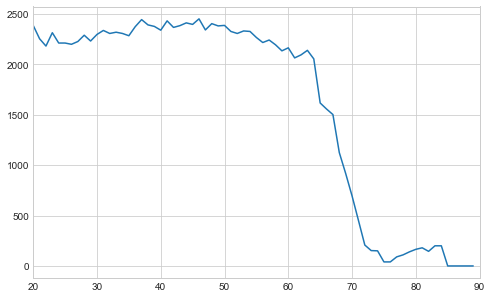

In [413]:
hs = []
for i in range(model.par.Tmin, model.par.T):
    h = model.sim.h[i, :]
    #print(h)
    hh = egm.util( model.sim.h[i, :] , model.sim.h[i, :][0], i, model.par)
    #h = model.sim.h[i, :]
    #print(i)
    h = np.average(h)
    hs.append(h)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(model.par.Tmin, model.par.T)
ax.plot(list(range(model.par.Tmin, model.par.T)) , hs)

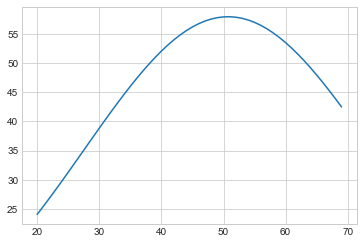

In [414]:
vs = []
ds = []
years = list(range(20, 70))
for i in years:
    ds.append( egm.human_capital(1, i, model.par) )
    vs.append( egm.util_bequest(10*i, model.par, False) )
plt.plot(years, ds)
#plt.plot(vs)

[25, 40, 50, 60, 70, 80]
275.137821472432
251.85265464707743
218.73788238460912
176.94448107957433
116.05042554837111
68.76648777256229


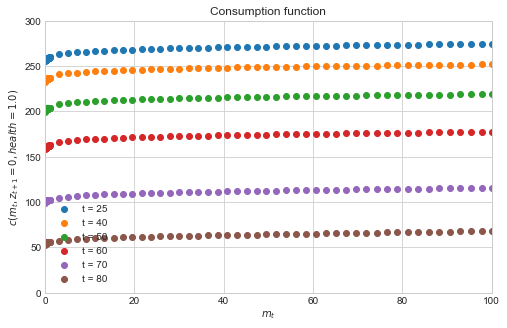

[25, 40, 50, 60, 70, 80]
277.7165155880578
256.0908241779397
223.26303911112072
180.72571357414301
117.73685562031683
68.36077810235007


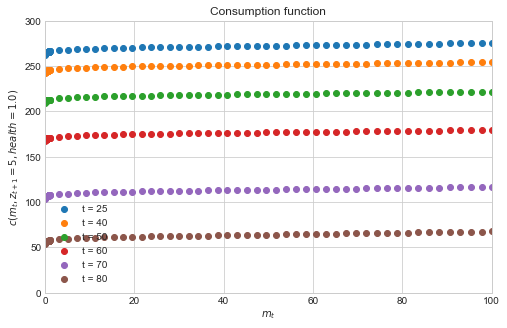

In [429]:
# Figure
def figure_multi_dim(par,sol,T,i_h):
    p = par.grid_e[i_h]

    ts = [25, 40, 50, 60, 70, 80]
    print(ts)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    
    for i in ts:
        print(np.average(sol.v[i-1,T,:,i_h]))
        ax.scatter(par.grid_m,sol.v[i-1,T,:,i_h], label=f't = {i}')
    ax.set_xlabel(f"$m_t$")
    ax.set_ylabel(f"$c(m_t,z_{{t+1}} = {T}, health = {p:.3})$")
    ax.set_xlim([0, 100])
    ax.set_ylim([0,300])
    ax.set_title(f'Consumption function')
    plt.legend()
    plt.show()

figure_multi_dim(model.par,model.sol, 0, 99)
figure_multi_dim(model.par,model.sol, 5, 99)
#figure_multi_dim(model.par,model.sol, 10, 50)
#figure_multi_dim(model.par,model.sol, 30, 50)

In [439]:
egm.util(10, 0, 10, model.par)


-0.1

In [438]:
c = 10
par.zeta = model.par.zeta
print(par.zeta)
((c**(1.0-par.zeta))/(1.0-par.zeta))

2


-0.1

In [15]:
def soft_max(x, y):
    v = 0.1
    return v * np.log(np.exp(x/v) + np.exp(y/v))
soft_max(40,2)

40.0